In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates()

,timestamp,domain,trafficType,accessType,y,x
0,1566896400,ru.wikipedia,spider,desktop,4,40
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241
2,1566882000,en.wikipedia,spider,desktop,10,61
3,1566871200,en.wikipedia,spider,desktop,14,14
4,1566864000,en.wikipedia,user,desktop,3,330
...,...,...,...,...,...,...
463375,1567274400,es.wikipedia,user,mobile-web,37,1
463376,1567260000,es.wikipedia,user,mobile-web,5108,1
463377,1567252800,es.wikipedia,user,desktop,8,1
463378,1567252800,de.wikipedia,user,mobile-app,76,1


In [12]:
df = pd.concat([
    pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/sep2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/oct2019.parquet").drop_duplicates(),
], axis=0, ignore_index=True)

df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df

,timestamp,domain,trafficType,accessType,y,x,date
0,1566896400,ru.wikipedia,spider,desktop,4,40,2019-08-27 09:00:00
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241,2019-08-27 07:00:00
2,1566882000,en.wikipedia,spider,desktop,10,61,2019-08-27 05:00:00
3,1566871200,en.wikipedia,spider,desktop,14,14,2019-08-27 02:00:00
4,1566864000,en.wikipedia,user,desktop,3,330,2019-08-27 00:00:00
...,...,...,...,...,...,...,...
1099125,1570154400,ru.wikipedia,user,mobile-web,9,1,2019-10-04 02:00:00
1099126,1570179600,en.wikipedia,user,desktop,36,4,2019-10-04 09:00:00
1099127,1570136400,de.wikipedia,user,mobile-app,562,1,2019-10-03 21:00:00
1099128,1570140000,en.wikipedia,user,mobile-web,13596,1,2019-10-03 22:00:00


In [211]:
def bucketmaker(df, minbin=0, maxbin=6, bincount=21):

    binstarts = np.logspace(minbin, maxbin, bincount)
    binends = np.roll(binstarts, -1)
    binends[-1] = np.inf
    occurences = np.zeros_like(binstarts)

    for _, (x, y) in df[["x", "y"]].iterrows():
        for i, (start, end) in enumerate(zip(binstarts, binends)):
            if (y >= start) and (y < end):
                occurences[i] += x

    probabilities = occurences / np.sum(occurences)

    return probabilities

In [212]:
def bucketmaker_np(df, minbin=0, maxbin=6, bincount=21):
    dist = []

    for _, (x, y) in df[["x", "y"]].iterrows():
        dist += [y] * x

    logdist = np.log10(dist)

    hist = np.histogram(logdist, bins=bincount, range=(minbin, maxbin), density=False)

    occurences, bins = hist
    probability = occurences/np.sum(occurences)

    return probability

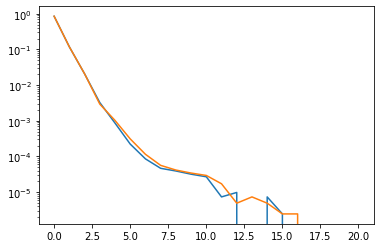

False


In [216]:
plt.plot(bucketmaker(smalldf))
plt.plot(bucketmaker_np(smalldf))
plt.yscale("log")
plt.show()

print(np.allclose(bucketmaker(smalldf), bucketmaker_np(smalldf)))

# %timeit bucketmaker(smalldf)
# %timeit bucketmaker_np(smalldf)
# plt.yscale("log")

In [117]:
smalldf = df[(df["timestamp"] == 1566896400)]
smallerdf = 

In [221]:
grouped_df = smalldf.groupby(["domain", "date"]).apply(bucketmaker).reset_index()
grouped_df[[f"{i:.3f}" for i in np.logspace(0,6,21)]] = grouped_df.apply(lambda row: row[0], axis=1, result_type="expand")
grouped_df.drop(columns=0, inplace=True)
grouped_df

,domain,date,1.000,1.995,3.981,7.943,15.849,31.623,63.096,125.893,...,1995.262,3981.072,7943.282,15848.932,31622.777,63095.734,125892.541,251188.643,501187.234,1000000.000
0,de.wikipedia,2019-08-27 09:00:00,0.804267,0.162260,0.026258,0.004506,0.001589,0.000599,0.000182,0.000052,...,0.00000,0.000026,0.0,0.000026,0.000000,0.0,0.0,0.0,0.0,0.0
1,en.wikipedia,2019-08-27 09:00:00,0.857259,0.117775,0.020385,0.003433,0.000840,0.000161,0.000058,0.000024,...,0.00001,0.000000,0.0,0.000007,0.000003,0.0,0.0,0.0,0.0,0.0
2,es.wikipedia,2019-08-27 09:00:00,0.896555,0.091696,0.008569,0.001325,0.000707,0.000442,0.000177,0.000265,...,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,fr.wikipedia,2019-08-27 09:00:00,0.835866,0.132541,0.026565,0.002628,0.000971,0.000571,0.000171,0.000229,...,0.00000,0.000057,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,ru.wikipedia,2019-08-27 09:00:00,0.901957,0.079783,0.015815,0.001685,0.000380,0.000109,0.000082,0.000054,...,0.00000,0.000027,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,zh.wikipedia,2019-08-27 09:00:00,0.835172,0.128407,0.032690,0.002271,0.000568,0.000162,0.000243,0.000081,...,0.00000,0.000081,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [222]:
grouped_df = df.groupby(["domain", "date"]).apply(bucketmaker).reset_index()
grouped_df[[f"{i:.3f}" for i in np.logspace(0,6,21)]] = grouped_df.apply(lambda row: row[0], axis=1, result_type="expand")
grouped_df.drop(columns=0, inplace=True)
grouped_df

,domain,date,1.000,1.995,3.981,7.943,15.849,31.623,63.096,125.893,...,1995.262,3981.072,7943.282,15848.932,31622.777,63095.734,125892.541,251188.643,501187.234,1000000.000
0,de.wikipedia,2019-08-01 00:00:00,0.838345,0.144581,0.012844,0.002682,0.000567,0.000516,0.000052,0.000052,...,0.000000,0.000103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,de.wikipedia,2019-08-01 01:00:00,0.868595,0.114275,0.013449,0.001953,0.000751,0.000451,0.000000,0.000301,...,0.000075,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,de.wikipedia,2019-08-01 02:00:00,0.885971,0.094074,0.015463,0.002246,0.001209,0.000432,0.000000,0.000346,...,0.000086,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,de.wikipedia,2019-08-01 03:00:00,0.875372,0.107582,0.011980,0.002412,0.001126,0.000884,0.000161,0.000161,...,0.000080,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,de.wikipedia,2019-08-01 04:00:00,0.838555,0.136675,0.018270,0.003689,0.001171,0.000761,0.000351,0.000234,...,0.000000,0.000059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,zh.wikipedia,2019-10-12 19:00:00,0.904214,0.074980,0.018320,0.000916,0.000262,0.000393,0.000131,0.000131,...,0.000000,0.000131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10508,zh.wikipedia,2019-10-12 20:00:00,0.936463,0.050258,0.011219,0.000801,0.000343,0.000229,0.000000,0.000229,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10509,zh.wikipedia,2019-10-12 21:00:00,0.943494,0.043052,0.010655,0.001184,0.000646,0.000108,0.000215,0.000215,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10510,zh.wikipedia,2019-10-12 22:00:00,0.927760,0.054469,0.014721,0.001893,0.000105,0.000210,0.000210,0.000210,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
